# 01 Import libraries

In [1]:
import numpy as np
import torch


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
from scipy.optimize import minimize

In [4]:
import importlib

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\dongq\\OneDrive\\Desktop\\New results\\Portfolio Allocation\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [7]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.naive_grid_search_2d import naive_grid_search_2d
from lib.ngs.utils_ngs_2d import get_losses_2d
from lib.ngs.loss_fn import allocation_cost

# 02 Load data

In [68]:
# file path for Colab. May need to change this
# X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
# y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')
decomp_cov_df = pd.read_csv('decomp_pert_20_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [69]:
decomp_cov_np = np.array(decomp_cov_df)
mean_np = np.array(mean_df).squeeze()

In [95]:
# uncomment and run this cell to replace the covariance matrix with eye

identity_matrix = np.eye(len(decomp_cov_np))
decomp_cov_np = identity_matrix

# 03 Compute the true solution path

We use the Naive Grid Search with $2^{10}$ grids, trained by full gradient descent with tuned learning rate = $2$ and 5000 iterations on each grid, to generate a true solution path.

In [36]:
lam_max_2d = [1, 1]
lam_min_2d = [.2, 0]
input_dim = decomp_cov_np.shape[1]

In [70]:
num_grid_2d = [20, 20]
hyper_params_2d = [[[lam_1, lam_2] for lam_2 in np.linspace(lam_max_2d[1], lam_min_2d[1], num_grid_2d[1])] for lam_1 in np.linspace(lam_max_2d[0], lam_min_2d[0], num_grid_2d[0])]
hyper_params_2d

[[[np.float64(1.0), np.float64(1.0)],
  [np.float64(1.0), np.float64(0.9473684210526316)],
  [np.float64(1.0), np.float64(0.8947368421052632)],
  [np.float64(1.0), np.float64(0.8421052631578947)],
  [np.float64(1.0), np.float64(0.7894736842105263)],
  [np.float64(1.0), np.float64(0.736842105263158)],
  [np.float64(1.0), np.float64(0.6842105263157895)],
  [np.float64(1.0), np.float64(0.631578947368421)],
  [np.float64(1.0), np.float64(0.5789473684210527)],
  [np.float64(1.0), np.float64(0.5263157894736843)],
  [np.float64(1.0), np.float64(0.4736842105263158)],
  [np.float64(1.0), np.float64(0.42105263157894735)],
  [np.float64(1.0), np.float64(0.368421052631579)],
  [np.float64(1.0), np.float64(0.3157894736842106)],
  [np.float64(1.0), np.float64(0.26315789473684215)],
  [np.float64(1.0), np.float64(0.21052631578947367)],
  [np.float64(1.0), np.float64(0.1578947368421053)],
  [np.float64(1.0), np.float64(0.10526315789473695)],
  [np.float64(1.0), np.float64(0.052631578947368474)],
  [np

In [49]:
hyper_params_vector = np.array(hyper_params_2d).ravel()
hyper_params_vector

array([1.        , 1.        , 1.        , 0.94736842, 1.        ,
       0.89473684, 1.        , 0.84210526, 1.        , 0.78947368,
       1.        , 0.73684211, 1.        , 0.68421053, 1.        ,
       0.63157895, 1.        , 0.57894737, 1.        , 0.52631579,
       1.        , 0.47368421, 1.        , 0.42105263, 1.        ,
       0.36842105, 1.        , 0.31578947, 1.        , 0.26315789,
       1.        , 0.21052632, 1.        , 0.15789474, 1.        ,
       0.10526316, 1.        , 0.05263158, 1.        , 0.        ,
       0.95789474, 1.        , 0.95789474, 0.94736842, 0.95789474,
       0.89473684, 0.95789474, 0.84210526, 0.95789474, 0.78947368,
       0.95789474, 0.73684211, 0.95789474, 0.68421053, 0.95789474,
       0.63157895, 0.95789474, 0.57894737, 0.95789474, 0.52631579,
       0.95789474, 0.47368421, 0.95789474, 0.42105263, 0.95789474,
       0.36842105, 0.95789474, 0.31578947, 0.95789474, 0.26315789,
       0.95789474, 0.21052632, 0.95789474, 0.15789474, 0.95789

In [71]:
n = len(hyper_params_vector) // 2  # Calculate n based on the vector size
hyper_params_matrix = hyper_params_vector.reshape(n, 2)
hyper_params_matrix

array([[1.        , 1.        ],
       [1.        , 0.94736842],
       [1.        , 0.89473684],
       [1.        , 0.84210526],
       [1.        , 0.78947368],
       [1.        , 0.73684211],
       [1.        , 0.68421053],
       [1.        , 0.63157895],
       [1.        , 0.57894737],
       [1.        , 0.52631579],
       [1.        , 0.47368421],
       [1.        , 0.42105263],
       [1.        , 0.36842105],
       [1.        , 0.31578947],
       [1.        , 0.26315789],
       [1.        , 0.21052632],
       [1.        , 0.15789474],
       [1.        , 0.10526316],
       [1.        , 0.05263158],
       [1.        , 0.        ],
       [0.95789474, 1.        ],
       [0.95789474, 0.94736842],
       [0.95789474, 0.89473684],
       [0.95789474, 0.84210526],
       [0.95789474, 0.78947368],
       [0.95789474, 0.73684211],
       [0.95789474, 0.68421053],
       [0.95789474, 0.63157895],
       [0.95789474, 0.57894737],
       [0.95789474, 0.52631579],
       [0.

In [72]:
# Define the objective function
def objective(theta, Sigma, mu, const, hyper_params):
    # print(Sigma, mu, const, hyper_params)
    quadratic_term = hyper_params[0] * (theta.T @ Sigma @ theta)
    linear_term = -hyper_params[1] * (mu.T @ theta)
    regularizer = np.sum(np.sqrt(theta**2 + const**2) - const)
    
    return quadratic_term + linear_term + regularizer

# Define the equality constraint: sum(theta) = 1
def constraint(theta):
    return np.sum(theta) - 1

In [114]:
const = .01

# Initial guess for theta
initial_theta = np.zeros(input_dim)

cov = decomp_cov_np.T @ decomp_cov_np

# Define the constraint in a dictionary format for the 'minimize' function
cons = {'type': 'eq', 'fun': constraint}

In [115]:
cov

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [116]:
weights = []
losses = []
for i in range(len(hyper_params_matrix)):
    hyper_params = hyper_params_matrix[i]
    # Run the optimization using 'trust-constr' method
    result = minimize(
        fun=objective,  # Objective function
        x0=initial_theta,  # Initial guess for theta
        args=(cov, mean_np, const, hyper_params),  # Arguments passed to the objective function
        method='trust-constr',  # Trust-region optimization method
        constraints=cons  # Constraints
    )
    if i % 100 == 0:
        print(f"first {i} results found")
    weights.append(result.x)
    losses.append(result.fun)

c:\Users\dongq\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


first 0 results found


c:\Users\dongq\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


first 100 results found
first 200 results found
first 300 results found


In [117]:
weights

[array([0.00883893, 0.29824785, 0.02169257, 0.01135333, 0.32806988,
        0.08807915, 0.14679868, 0.02031644, 0.01051898, 0.06608419]),
 array([0.0113071 , 0.30855532, 0.02935564, 0.01238737, 0.35179744,
        0.00592488, 0.15931448, 0.02813233, 0.01343314, 0.0797923 ]),
 array([0.01240859, 0.30097515, 0.03323677, 0.0136019 , 0.34181016,
        0.00665323, 0.16004319, 0.03182403, 0.01476861, 0.08467839]),
 array([0.01366245, 0.29293405, 0.03768456, 0.01499672, 0.33136193,
        0.00744294, 0.16031447, 0.03609323, 0.01631478, 0.08919487]),
 array([0.05360754, 0.25565741, 0.03040907, 0.06134893, 0.28964474,
        0.00771527, 0.13837886, 0.02922399, 0.05859285, 0.07542133]),
 array([0.07299354, 0.24349907, 0.04511219, 0.05801311, 0.27194978,
        0.00588755, 0.1450748 , 0.04315024, 0.02304836, 0.09127135]),
 array([0.01736815, 0.2636489 , 0.05341176, 0.02102706, 0.29451963,
        0.02296867, 0.1562918 , 0.0513081 , 0.01834201, 0.10111393]),
 array([0.06487719, 0.22787974, 0.

In [118]:
losses

[np.float64(-0.21909208130294522),
 np.float64(-0.190589222481078),
 np.float64(-0.11511159382352765),
 np.float64(-0.04031412289120684),
 np.float64(0.054058790913487975),
 np.float64(0.12361044635408602),
 np.float64(0.18131393283804076),
 np.float64(0.27229934917816667),
 np.float64(0.331464802865834),
 np.float64(0.40411666592024575),
 np.float64(0.47029321437043703),
 np.float64(0.5262202179523555),
 np.float64(0.5918746259405068),
 np.float64(0.6560619338921705),
 np.float64(0.7186761345569681),
 np.float64(0.7796084863438386),
 np.float64(0.8387614446326954),
 np.float64(0.8960650549380131),
 np.float64(0.9514793143710664),
 np.float64(1.0049875621120887),
 np.float64(-0.2766100466507303),
 np.float64(-0.20137882860392897),
 np.float64(-0.10806458285997089),
 np.float64(0.015827328754706826),
 np.float64(0.024259104192348335),
 np.float64(0.09798207703429285),
 np.float64(0.1725375805436884),
 np.float64(0.24285308801963013),
 np.float64(0.31380632670572084),
 np.float64(0.38369

In [119]:
n = len(losses) // num_grid_2d[1]  # Calculate n based on the vector size
losses_2d = np.array(losses).reshape(n, num_grid_2d[1])
losses_2d

array([[-0.21909208, -0.19058922, -0.11511159, -0.04031412,  0.05405879,
         0.12361045,  0.18131393,  0.27229935,  0.3314648 ,  0.40411667,
         0.47029321,  0.52622022,  0.59187463,  0.65606193,  0.71867613,
         0.77960849,  0.83876144,  0.89606505,  0.95147931,  1.00498756],
       [-0.27661005, -0.20137883, -0.10806458,  0.01582733,  0.0242591 ,
         0.09798208,  0.17253758,  0.24285309,  0.31380633,  0.38369743,
         0.45498704,  0.51989211,  0.58596963,  0.65055346,  0.71352989,
         0.7747814 ,  0.83419684,  0.89169539,  0.94722885,  1.00077704],
       [-0.28939987, -0.21246444, -0.13613539, -0.06046218,  0.01449886,
         0.11816677,  0.16408312,  0.23446728,  0.3076702 ,  0.37629133,
         0.44659713,  0.51697053,  0.58311421,  0.6449485 ,  0.70831088,
         0.76990322,  0.82960226,  0.88731613,  0.94297592,  0.99656651],
       [-0.17117379, -0.14013422, -0.1470976 ,  0.003319  ,  0.02645038,
         0.07911354,  0.15294544,  0.22739459,  

In [120]:
losses_2d.shape

(20, 20)

In [121]:
thetas_list = pd.DataFrame(np.column_stack([hyper_params_matrix, np.array(weights)[:, 1:]]))

# Save the DataFrame to a CSV file
thetas_list.to_csv('thetastar_eye_001_20_20.csv', index=False)

In [122]:
exact_soln_list = pd.DataFrame(losses_2d)

# Save the DataFrame to a CSV file
exact_soln_list.to_csv('exact_soln_list_eye_001_20_20.csv', index=False)

In [81]:
# Read the CSV file into a DataFrame
truth = pd.read_csv('exact_soln_list_pert_20_001_100_100.csv')

# Display the DataFrame
truth

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,16.713356,16.721987,16.730616,16.739244,16.747871,16.756496,16.765119,16.773741,16.782361,16.790979,...,17.483909,17.492400,17.500889,17.509377,17.517863,17.526347,17.534830,17.543312,17.551792,17.560270
1,16.579523,16.588156,16.596787,16.605416,16.614044,16.622670,16.631294,16.639917,16.648539,16.657158,...,17.350144,17.358635,17.367124,17.375612,17.384099,17.392583,17.401066,17.409548,17.418028,17.426506
2,16.445688,16.454322,16.462954,16.471584,16.480213,16.488841,16.497467,16.506091,16.514714,16.523335,...,17.216377,17.224868,17.233358,17.241846,17.250332,17.258817,17.267300,17.275782,17.284262,17.292740
3,16.311849,16.320485,16.329118,16.337750,16.346380,16.355009,16.363636,16.372262,16.380885,16.389508,...,17.082608,18.871977,17.099589,17.108077,17.116564,17.125049,17.133532,17.142014,17.150494,17.158972
4,16.178008,16.186644,16.195279,16.203912,16.212544,16.221174,16.229802,16.238429,16.247054,16.255678,...,16.948837,16.957329,16.965819,16.974307,16.982793,16.991278,16.999762,17.008244,17.016724,17.025202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.948467,3.957633,3.966792,3.975945,3.985090,3.994230,4.003362,4.012488,4.021608,4.030720,...,4.746876,4.755447,4.764011,4.772568,4.781119,4.789663,4.798201,4.806732,4.815256,4.823774
96,3.812096,3.821286,3.830469,3.839645,3.848814,3.857977,3.867133,3.876282,3.885424,3.894559,...,4.611750,4.620324,4.628891,4.637451,4.646005,4.654551,4.663091,4.671624,4.680150,4.688670
97,3.675582,3.684798,3.694007,3.703209,3.712403,3.721591,3.730771,3.739944,3.749110,3.758270,...,4.476566,4.485143,4.493713,4.502276,4.510832,4.519381,4.527923,4.536458,4.544986,4.553507
98,3.538917,3.548160,3.557397,3.566626,3.575847,3.585062,3.594268,3.603468,3.612660,3.621845,...,4.341322,4.349903,4.358476,4.367042,4.375601,4.384152,4.392697,4.401233,4.409763,4.418285


In [54]:
import matplotlib.pyplot as plt

In [145]:
# Read the CSV file into a DataFrame
thetastar = pd.read_csv('thetastar_cov_001_20_20.csv')

# Display the DataFrame
thetastar

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,1.000000,-0.037976,-0.190117,-0.023968,0.036072,0.042990,0.086302,0.331900,0.318086,0.003991
1,1.0,0.947368,-0.037776,-0.189987,-0.024094,0.034380,0.044280,0.085905,0.332158,0.318135,0.003884
2,1.0,0.894737,-0.037579,-0.189868,-0.024219,0.032721,0.045574,0.085489,0.332412,0.318182,0.003777
3,1.0,0.842105,-0.037386,-0.189759,-0.024343,0.031096,0.046871,0.085051,0.332661,0.318229,0.003671
4,1.0,0.789474,-0.037197,-0.189662,-0.024466,0.029512,0.048171,0.084589,0.332906,0.318275,0.003565
...,...,...,...,...,...,...,...,...,...,...,...
395,0.2,0.210526,-0.009184,0.000159,-0.005201,0.012190,0.017044,0.020183,0.297778,0.330477,0.003439
396,0.2,0.157895,-0.009494,0.000120,-0.005187,0.011051,0.018330,0.018811,0.296700,0.330120,0.003308
397,0.2,0.105263,-0.009841,0.000077,-0.005177,0.010048,0.019775,0.017572,0.295444,0.329734,0.003171
398,0.2,0.052632,-0.010225,0.000030,-0.005172,0.009154,0.021405,0.016455,0.294025,0.329320,0.003031


In [148]:
thetastar = thetastar.to_numpy()

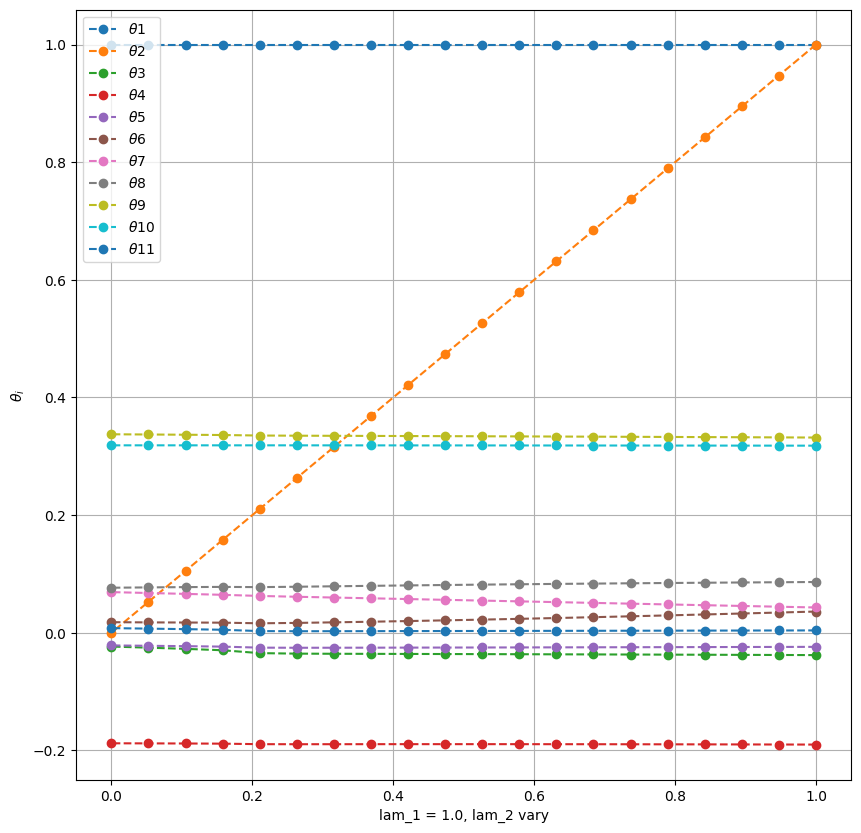

In [151]:
# plot result of our method:
plt.figure(figsize=(10,10))
start = 0
for i in range(2, len(thetastar[0])):
    plt.plot(thetastar[start:start+20, 1], thetastar[start:start+20, i], '--o', label=f'$\\theta${i-1}')
# i=5
# plt.plot(thetastar[start:start+10, 1], thetastar[start:start+10, i], '--o', label=f'lam_1 = {thetastar[start, 0]}, $\\theta${i+1}')
plt.xlabel(f'lam_1 = {thetastar[start, 0]}, lam_2 vary')
plt.ylabel(f"$\\theta_i$")
plt.legend()
plt.grid(True)

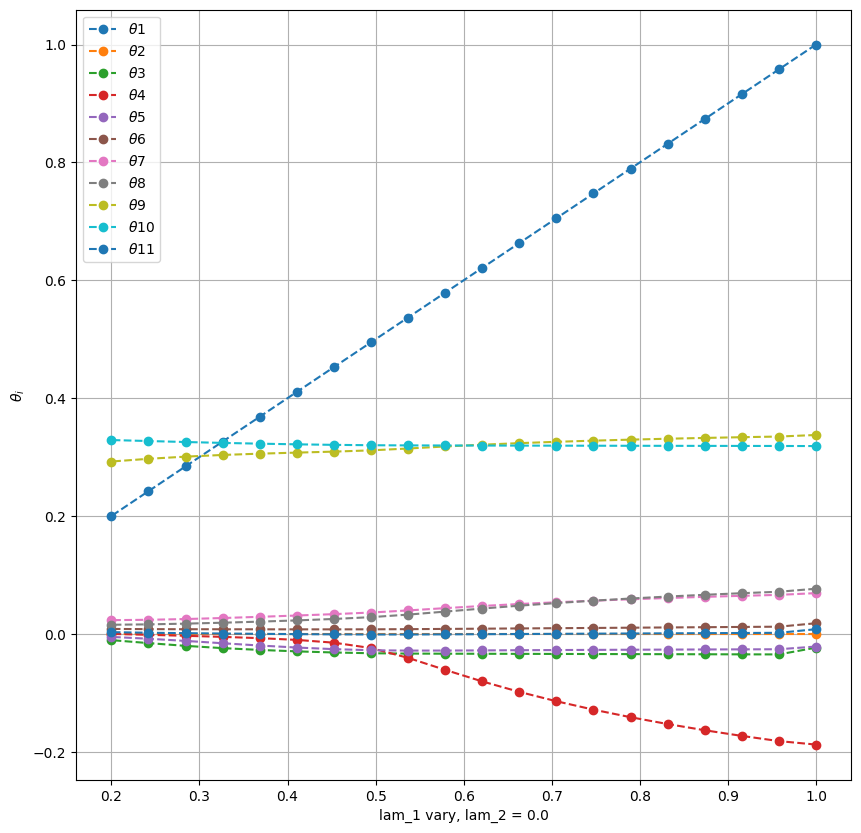

In [155]:
# plot result of our method:
plt.figure(figsize=(10,10))
start = 19
indices = np.arange(start, 400+start, 20)
for i in range(2, len(thetastar[0])):
    plt.plot(thetastar[indices, 0], thetastar[indices, i], '--o', label=f'$\\theta${i-1}')
# i=5
# plt.plot(thetastar[start:start+10, 1], thetastar[start:start+10, i], '--o', label=f'lam_1 = {thetastar[start, 0]}, $\\theta${i+1}')
plt.xlabel(f'lam_1 vary, lam_2 = {thetastar[start, 1]}')
plt.ylabel(f"$\\theta_i$")
plt.legend()
plt.grid(True)